In [1]:
import keras
from keras.models import load_model
from keras import utils

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K
from keras import regularizers

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time

target_names = ["Knuckle", "Finger"]

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
# the data, split between train and test sets
df = pd.read_pickle("DataStudyCollection/df_blobs_area.pkl")

lst = df.userID.unique()
np.random.seed(42)
np.random.shuffle(lst)
test_ids = lst[-5:]
train_ids = lst[:-5]
print(train_ids, test_ids)
print(len(train_ids), ":", len(test_ids))
print(len(train_ids) / len(lst), ":", len(test_ids)/ len(lst))

df = df[df.userID.isin(train_ids) | df.userID.isin(test_ids) & (df.Version == "Normal")]
print(len(df))

[ 1  2  9  6  4 14 17 16 12  3 10 18  5] [13  8 11 15  7]
13 : 5
0.7222222222222222 : 0.2777777777777778
503886


In [3]:
x = np.vstack(df.Blobs)
x = x.reshape(-1, 27, 15, 1)

In [4]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y = utils.to_categorical(df.InputMethod, num_classes)

Text(0.5, 1.0, 'Label for image 1 is: [1. 0.]')

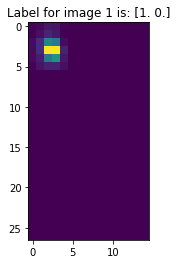

In [5]:
i = 1
plt.imshow(x[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y[i]))

In [6]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.4

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [7]:
loadpath = "./ModelSnapshots/CNN-33767.h5"
model = load_model(loadpath)

In [8]:
%%time
lst = []
batch = 100
for i in range(0, len(x), batch):
    _x = x[i: i+batch]
    lst.extend(model.predict(_x))

CPU times: user 1min 28s, sys: 9.52 s, total: 1min 37s
Wall time: 1min


In [9]:
df["InputMethodPred"] = lst
df.InputMethodPred = df.InputMethodPred.apply(lambda x: np.argmax(x))

In [10]:
df_train = df[df.userID.isin(train_ids)]
df_test = df[df.userID.isin(test_ids) & (df.Version == "Normal")]

In [11]:
print(sklearn.metrics.confusion_matrix(df_train.InputMethod.values, df_train.InputMethodPred.values, labels=[0, 1]))
cm = sklearn.metrics.confusion_matrix(df_train.InputMethod.values, df_train.InputMethodPred.values, labels=[0, 1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
print("Accuray: %.3f" % sklearn.metrics.accuracy_score(df_train.InputMethod.values, df_train.InputMethodPred.values))
print("Recall: %.3f" % metrics.recall_score(df_train.InputMethod.values, df_train.InputMethodPred.values, average="macro"))
print("Precision: %.3f" % metrics.average_precision_score(df_train.InputMethod.values, df_train.InputMethodPred.values, average="macro"))
#print("F1-Score: %.3f" % metrics.f1_score(df_train.InputMethod.values, df_train.InputMethodPred.values, average="macro"))
print(sklearn.metrics.classification_report(df_train.InputMethod.values, df_train.InputMethodPred.values, target_names=target_names))

[[124207  12765]
 [  6596 322276]]
[[0.90680577 0.09319423]
 [0.02005644 0.97994356]]
Accuray: 0.958
Recall: 0.943
Precision: 0.957
              precision    recall  f1-score   support

     Knuckle       0.95      0.91      0.93    136972
      Finger       0.96      0.98      0.97    328872

   micro avg       0.96      0.96      0.96    465844
   macro avg       0.96      0.94      0.95    465844
weighted avg       0.96      0.96      0.96    465844



In [12]:
print(sklearn.metrics.confusion_matrix(df_test.InputMethod.values, df_test.InputMethodPred.values, labels=[0, 1]))
cm = sklearn.metrics.confusion_matrix(df_test.InputMethod.values, df_test.InputMethodPred.values, labels=[0, 1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
print("Accuray: %.3f" % sklearn.metrics.accuracy_score(df_test.InputMethod.values, df_test.InputMethodPred.values))
print("Recall: %.3f" % metrics.recall_score(df_test.InputMethod.values, df_test.InputMethodPred.values, average="macro"))
print("Precision: %.3f" % metrics.average_precision_score(df_test.InputMethod.values, df_test.InputMethodPred.values, average="macro"))
#print("F1-Score: %.3f" % metrics.f1_score(df_test.InputMethod.values, df_test.InputMethodPred.values, average="macro"))
print(sklearn.metrics.classification_report(df_test.InputMethod.values, df_test.InputMethodPred.values, target_names=target_names))

[[ 8384  1037]
 [ 1028 27593]]
[[0.88992676 0.11007324]
 [0.03591768 0.96408232]]
Accuray: 0.946
Recall: 0.927
Precision: 0.956
              precision    recall  f1-score   support

     Knuckle       0.89      0.89      0.89      9421
      Finger       0.96      0.96      0.96     28621

   micro avg       0.95      0.95      0.95     38042
   macro avg       0.93      0.93      0.93     38042
weighted avg       0.95      0.95      0.95     38042



# Export

In [13]:
output_node_prefix = "output_node"
num_output = 1
pred = [None]*num_output
pred_node_names = [None]*num_output
for i in range(num_output):
    pred_node_names[i] = output_node_prefix+str(i)
    pred[i] = tf.identity(model.outputs[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)
output_node_prefix = pred_node_names[0]

output nodes names are:  ['output_node0']


In [14]:
model.inputs

[<tf.Tensor 'conv2d_1_input:0' shape=(?, 27, 15, 1) dtype=float32>]

In [15]:
sess = K.get_session()

In [16]:
output_path = "./Models/"
output_file = "CNN.pb"

In [17]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)

graph_io.write_graph(constant_graph, output_path, output_file, as_text=False)

print('Saved the freezed graph at: ', (output_path + output_file))

INFO:tensorflow:Froze 30 variables.
INFO:tensorflow:Converted 30 variables to const ops.
Saved the freezed graph at:  ./Models/CNN.pb
